In [1]:
from comet_ml import Experiment
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, BatchNormalization, ReLU, Conv2DTranspose, Concatenate, Add, GlobalAveragePooling2D, Activation, MaxPool2D
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
import sys
import importlib
import matplotlib.pyplot as plt
import time
import keras.backend as K
import numpy as np

In [2]:
!pip install comet_ml

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/DLProjects/JapaNet

experiment = Experiment(
    api_key="K5CvVquVZJNg9xfY2ip95FuoD",
    project_name="japanet",
    workspace="rcofre",
)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/DLProjects/JapaNet


COMET INFO: Experiment is live on comet.ml https://www.comet.ml/rcofre/japanet/fc0855c283744eaeadb83689b1c7572a



In [4]:
from dataloader import IdentifierDataset

In [5]:
datasetParams = {
    'identifierShufflingBufferSize': 4096,
    'classifierShufflingBufferSize': 100,
    'batchSize': 32,
    'identifierInputHeight': 512,
    'identifierInputWidth': 512,
    'identifierOutputStride': 4,
    'validationFraction': 0.2,
    'classifierInputWidth': 64,
    'classifierInputHeight': 64
}

dataset = IdentifierDataset(datasetParams)
trainData, validationData = dataset.load()

In [17]:
def convBatchReLU(x, numFilters, kernelSize=3, stride=1, padding="same", upsample=False):
    if upsample:
        x = Conv2DTranspose(numFilters, kernel_size=kernelSize, strides=stride, padding=padding)(x)
    else:    
        x = Conv2D(numFilters, kernel_size=kernelSize, strides=stride, padding=padding)(x)
    x = BatchNormalization()(x)
    return ReLU()(x)

class ResNet:
    def __init__(self, inputShape, numBlocks, numBlockFilters, numClasses=None):
        super(ResNet, self).__init__()
        self.inputShape = inputShape
        self.numBlocks = numBlocks
        self.numBlockFilters = numBlockFilters
        self.numClasses = numClasses

    def residualBlock(self, x, numFilters, stride):
        y = convBatchReLU(x, numFilters, stride=stride)
        y = convBatchReLU(y, numFilters)
        if stride == 2 or numFilters != x.shape[-1]:
            x = Conv2D(numFilters, 3, strides=stride, padding='same')(x)
        return Add()([x, y])

    def predict(self, x):
        return self.model.predict(x)

    def buildModel(self):
        inputLayer = Input(self.inputShape)
        x = convBatchReLU(inputLayer, 64, 7, 2)
        x = MaxPool2D((3, 3), strides=2, padding="same")(x)
        stride = 1
        for i in range(4):            
            for _ in range(self.numBlocks[i]):
                x = self.residualBlock(x, self.numBlockFilters[i], stride=stride)
                stride = 1
            stride = 2
        # At this point the dims are original / 2^5
        x = GlobalAveragePooling2D()(x)   # Now the outputs are a 1D vector of size 512
        if self.numClasses is not None:
            x = Dense(1000)(x)
            x = ReLU()(x)
            x = Dense(self.numClasses)(x)
        return Model(inputLayer, x)

class ResNet18(ResNet):
    def __init__(self, inputShape, numClasses=None):
        super(ResNet18, self).__init__(inputShape, [2] * 4, [64, 128, 256, 512], numClasses)
        self.model = self.buildModel()

class ResNet34(ResNet):
    def __init__(self, inputShape, numClasses=None):
        super(ResNet34, self).__init__(inputShape, [3, 4, 6, 3], [64, 128, 256, 512], numClasses)
        self.model = self.buildModel()

class CenterNet(ResNet):
    def __init__(self, inputShape, numBlocks, numBlockFilters, numClasses, inOutRatio=4):
        super(CenterNet, self).__init__(inputShape, numBlocks, numBlockFilters, numClasses)
        self.numOutputs = numClasses + 4
        assert isinstance(inOutRatio, int) and 0 < inOutRatio < 6
        self.inOutRatio = inOutRatio
        self.model = self.buildModel()

    def aggregationBlock(self, x, xSkip, numChannels, stride=2):
        x = convBatchReLU(x, numChannels, kernelSize=2, stride=stride, upsample=True)
        x = Concatenate()([x, xSkip])
        return convBatchReLU(x, numChannels, kernelSize=1, stride=1)

    def buildModel(self):
        inputLayer = Input(self.inputShape)
        xDown = []
        x = convBatchReLU(inputLayer, 64, 7, 2)
        xDown.append(x)
        x = MaxPool2D((3, 3), strides=2, padding="same")(x)
        xDown.append(x)
        stride = 1
        for i in range(4):            
            for _ in range(self.numBlocks[i]):
                x = self.residualBlock(x, self.numBlockFilters[i], stride=stride)
                stride = 1
            stride = 2
            if i > 0:
                xDown.append(x)

        x = AveragePooling2D((2, 2))(x) # At this point the dims are original / 2^6
        x = convBatchReLU(x, 1024, 1)

        for i in range(4, -1, -1):
            x = self.aggregationBlock(x, xDown[i], self.numBlockFilters[max(0, i - 1)])
            if self.inputShape[0] // x.shape[1]  <= self.inOutRatio:
                break
        x = Conv2D(self.numOutputs, kernel_size=3, strides=1, padding="same")(x)
        x = Activation("sigmoid")(x)
        return Model(inputLayer, x)

    def heatMapLoss(self, target, pred, mask=None):
        alpha = 2.
        beta = 4.
        if mask is None:
            mask = K.sign(target[:, :, :, 1])
        return -K.sum(target[:, :, :, 0] * ((1 - pred[:, :, :, 0]) ** alpha) * K.log(pred[:, :, :, 0] + 1e-6) + (
                    1 - target[:, :, :, 0]) * ((1 - mask) ** beta) * (pred[:, :, :, 0] ** alpha) * K.log(
            1 - pred[:, :, :, 0] + 1e-6))


    def offsetLoss(self, target, pred, mask=None):
        if mask is None:
            mask = K.sign(target[:, :, :, 1])
        return K.sum(
            K.abs(target[:, :, :, 3] - pred[:, :, :, 3] * mask) + K.abs(target[:, :, :, 4] - pred[:, :, :, 4] * mask))


    def sizeLoss(self, target, pred, mask=None):
        if mask is None:
            mask = K.sign(target[:, :, :, 1])
        return K.sum(
            K.abs(target[:, :, :, 1] - pred[:, :, :, 1] * mask) + K.abs(target[:, :, :, 2] - pred[:, :, :, 2] * mask))

    def loss(self, target, pred):
        mask = K.sign(target[:, :, :, 1])
        N = K.sum(mask)
        heatloss = self.heatMapLoss(target, pred, mask)
        offsetloss = self.offsetLoss(target, pred, mask)
        sizeloss = self.sizeLoss(target, pred, mask)
        return (heatloss + 1.0 * offsetloss + 5.0 * sizeloss) / N

In [18]:
centerNet = CenterNet([512, 512, 3], [2] * 4, [64, 128, 256, 512], 1)
resNet18 = ResNet18([512, 512, 3], numClasses=4200)
resNet34 = ResNet34([512, 512, 3], numClasses=4200)

In [21]:
for image, label in trainData:
    x1 = centerNet.predict(tf.reshape(image[imgIdx, :, :, :], (1, 512, 512, 3)))
    x2 = resNet18.predict(tf.reshape(image[imgIdx, :, :, :], (1, 512, 512, 3)))
    x3 = resNet34.predict(tf.reshape(image[imgIdx, :, :, :], (1, 512, 512, 3)))
    break
print(x1.shape)
print(x2.shape)
print(x3.shape)

(1, 128, 128, 5)
(1, 4200)
(1, 4200)


In [9]:
from keras.callbacks import LearningRateScheduler

def lrs(epoch):
    lr = 0.001
    if epoch >= 20: 
        lr = 0.0002
    return lr

lrSchedule = LearningRateScheduler(lrs)

In [10]:
def fitCenterNet(model, trainData, valData, n_epoch):
    hist = model.fit(
        trainData,
        epochs = n_epoch,
        validation_data=valData,
        callbacks = [lrSchedule],
        verbose = 1,
        validation_steps=1
    )
    return hist

centerNet.model.compile(loss=centerNet.loss, optimizer=Adam(lr=0.001), metrics=[centerNet.heatMapLoss, centerNet.sizeLoss, centerNet.offsetLoss])
hist = fitCenterNet(centerNet.model, trainData, validationData, 30)

COMET WARNING: tensorflow datasets are not currently supported for gradient and activation auto-logging
COMET WARNING: tensorflow datasets are not currently supported for gradient and activation auto-logging
COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE


Epoch 1/30
      6/Unknown - 7s 362ms/step - loss: 25.8017 - heatMapLoss: 127021.4688 - sizeLoss: 4715.2791 - offsetLoss: 6585.8167WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0434s vs `on_train_batch_end` time: 0.2660s). Check your callbacks.
90/90 [==============================] - 38s 374ms/step - loss: 6.3061 - heatMapLoss: 30154.3128 - sizeLoss: 1241.1859 - offsetLoss: 2039.3161 - val_loss: 4.7254 - val_heatMapLoss: 10100.5508 - val_sizeLoss: 1745.2728 - val_offsetLoss: 1265.6672
Epoch 2/30
90/90 [==============================] - 33s 364ms/step - loss: 1.2835 - heatMapLoss: 6998.3340 - sizeLoss: 140.1068 - offsetLoss: 30.6921 - val_loss: 3.7765 - val_heatMapLoss: 12735.5488 - val_sizeLoss: 593.7213 - val_offsetLoss: 353.3935
Epoch 3/30
90/90 [==============================] - 33s 364ms/step - loss: 1.1316 - heatMapLoss: 6320.0197 - sizeLoss: 106.9638 - offsetLoss: 27.8289 - val_loss: 3.8845 - val_heatMapLoss: 14652.3867

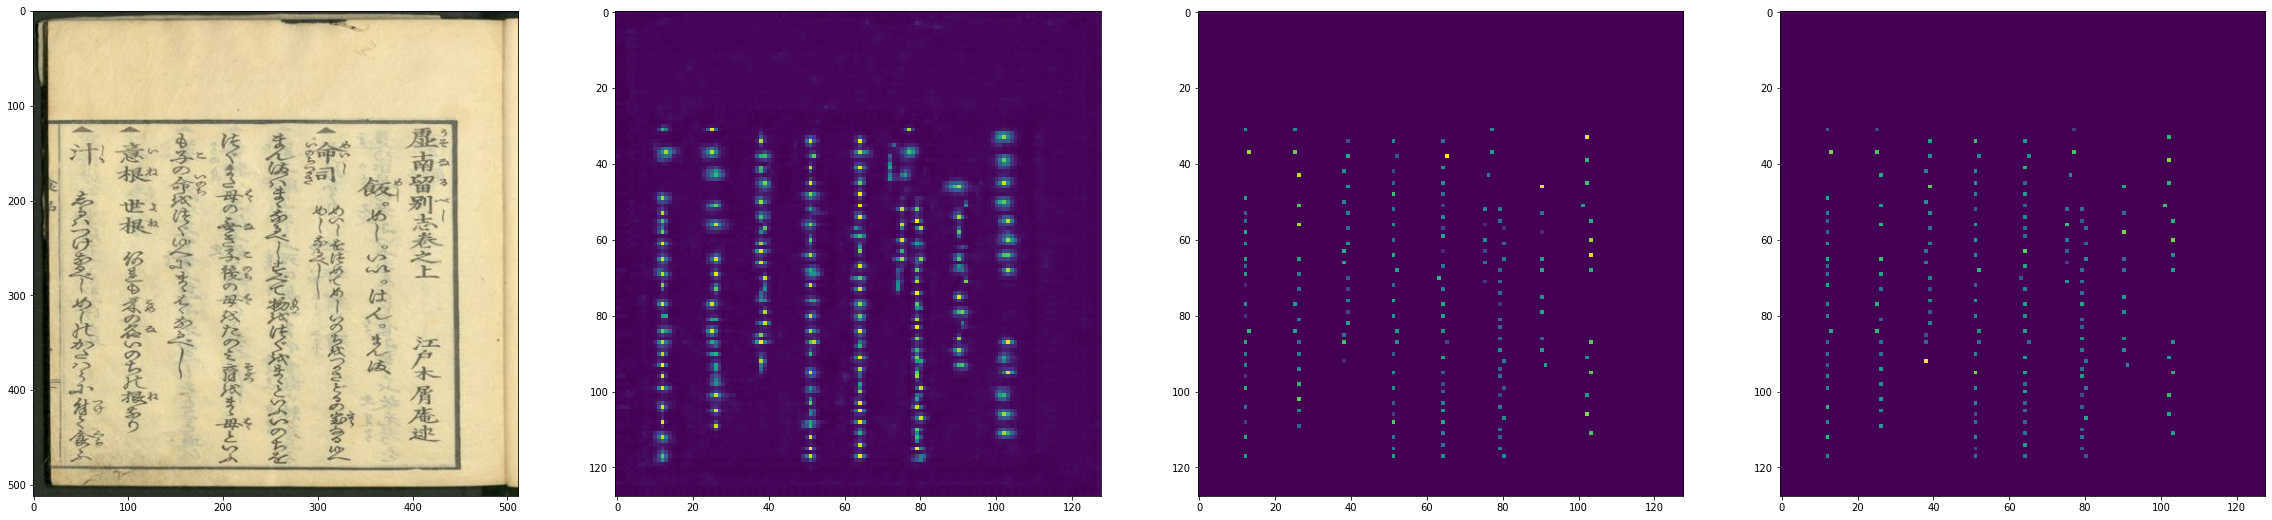

In [12]:
imgIdx = 0
for image, label in validationData:
    x = centerNet.predict(tf.reshape(image[imgIdx, :, :, :], (1, 512, 512, 3)))
    break
plt.figure(figsize=(40,10))
plt.subplot(1, 4, 1)
plt.imshow(image[imgIdx, :, :, :])
plt.subplot(1, 4, 2)
plt.imshow(x[0, :, :, 0])
plt.subplot(1, 4, 3)
plt.imshow(x[0, :, :, 1] * np.sign(label[imgIdx, :, :, 1])) 
plt.subplot(1, 4, 4)
plt.imshow(x[0, :, :, 2] * np.sign(label[imgIdx, :, :, 1]))